In [1]:
from src import *
from data.scanner.CAVA_V1 import *
import tikzplotlib

from torch.utils.tensorboard import SummaryWriter

gpu = 0
torch.cuda.set_device(gpu)

In [2]:
# # load phantom image and generate fully sampled k-space data of a single frame
# ref_imgs = np.array(np.load("data/xcat/phantom3/filtered_imgs.npy"), dtype=np.complex64)
# img = to_tensor(ref_imgs[0].T)
# del ref_imgs

# smaps = to_tensor(np.load("data/xcat/phantom3/low_res_as_cava_v1_10_smaps.npy")).squeeze() # Nc Ny Nx 2
# kspace = fft2(complex_mul(img.unsqueeze(dim=0), smaps)) # Nc Ny Nx 2


In [3]:
# load experimental dataset FB 10, single dynamic. Perform bart reconstruction and use as ground-truth
dataset_info = datasets_cava_v1[10]
dataset = CartesianSliceDataset.from_sparse_matfile2d(dataset_info["matfile_path"], dataset_info["listfile_path"], remove_padding=True, shift=True)

img = to_tensor(bart_l1_wavelet_reconstruction(dataset[41])).squeeze()
smaps = dataset.smaps.squeeze()
kspace = fft2(complex_mul(img.unsqueeze(dim=0), smaps)) # Nc Ny Nx 2

WARN: BART version is not reproducible.


ADMM Dynamic stepsize
Size: 49104 Samples: 10560 Acc: 4.65
Maximum eigenvalue: 1.07e+03
l1-wavelet regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 3.253464


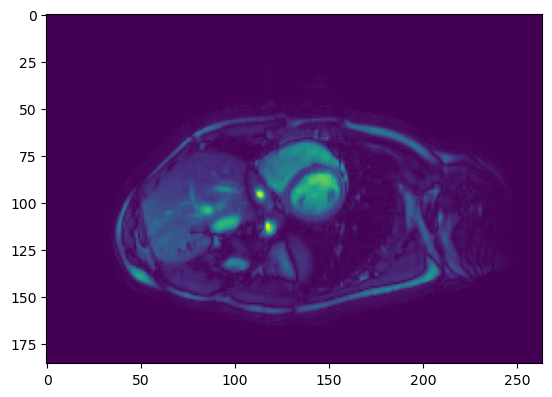

In [4]:
plt.imshow(root_sum_of_squares(img, dim=-1))

In [5]:
## create samples with sparse data representation (SparseCartesianDataset)
Nc, Ny, Nx, _ = kspace.shape


def extract_kspace_coordinates(kspace, mask): # z coordinate is ignored
    Ns, Nl, Nr, _ = mask.shape
    Nc, Ny, Nx, _ = kspace.shape
    mask_flattened = mask.flatten(end_dim=-2)
    return kspace[:, mask_flattened[:,1], mask_flattened[:,2], :].reshape((Ns, Nc, Nl, Nr, 2)) # (Ns=1, Nc, Nl, Nr, 2)


# fully sampled frame
mask_fully_sampled = torch.stack(torch.meshgrid(torch.tensor([0]), torch.arange(Ny), torch.arange(Nx)), dim=-1) # (Ns=1, Nl=Ny, Nr=Nx, 3)
trajectory_fully_sampled = mask_to_trajectory(mask_fully_sampled, 1, Ny, Nx)
kspace_fully_sampled = extract_kspace_coordinates(kspace, mask_fully_sampled)

sample_fully_sampled = {
    "kspace": kspace_fully_sampled,
    "trajectory": trajectory_fully_sampled,
    "mask": mask_fully_sampled,
    "t_k": 0.
}
sample_fully_sampled = copySampleToGPU(sample_fully_sampled)

# sub-sampled frame with the FB pattern
dataset_info = datasets_cava_v1[10]
dataset_fb = CartesianDataset.from_sparse_matfile2d(dataset_info["matfile_path"], dataset_info["listfile_path"], remove_padding=True)
ky_sampling_pattern = torch.nonzero(dataset_fb.mask[0, 0, :, int(dataset_fb.Nx/2)]).flatten()

num_lines = ky_sampling_pattern.numel()
mask_subsampled = torch.stack(torch.meshgrid(torch.tensor([0]), ky_sampling_pattern, torch.arange(Nx)), dim=-1) # (Ns=1, Nl=num_lines, Nr=Nx, 3)
trajectory_subsampled = mask_to_trajectory(mask_subsampled, 1, Ny, Nx) # (Ns=1, Nl=num_lines, Nr=Nx, 3)
kspace_subsampled = extract_kspace_coordinates(kspace, mask_subsampled)

sample_subsampled = {
    "kspace": kspace_subsampled,
    "trajectory": trajectory_subsampled,
    "mask": mask_subsampled,
    "t_k": 0.
}
sample_subsampled = copySampleToGPU(sample_subsampled)


sample = sample_subsampled

/opt/conda/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


2023-02-18 10:54:54.279438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 10:54:54.421456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-18 10:54:54.421473: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-18 10:54:54.441902: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registe

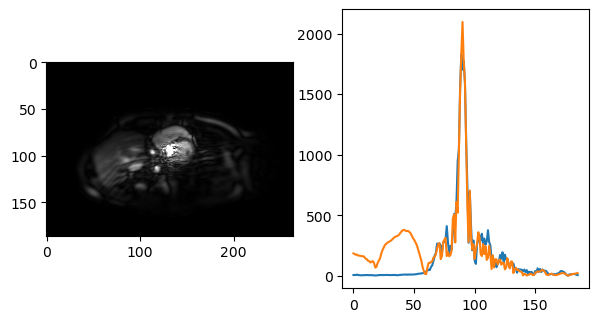

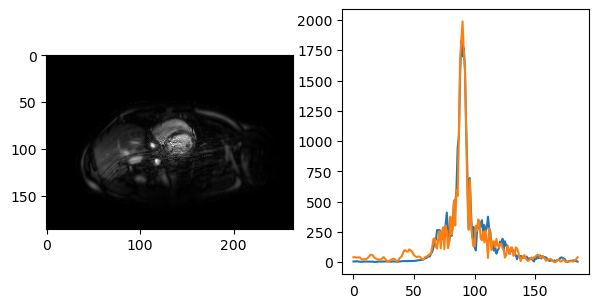

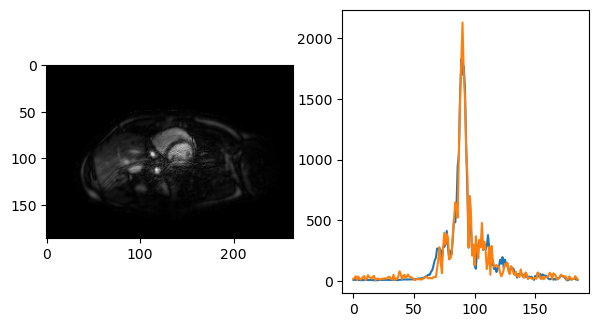

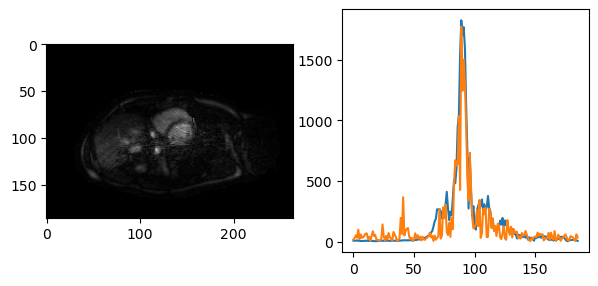

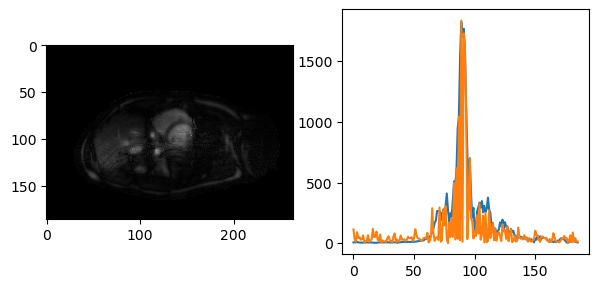

In [6]:
parameter1 = [1e0, 3e0, 1e1, 3e1, 1e2]
parameter2 = [0.]

final_losses = torch.zeros(len(parameter1), len(parameter2))
mses = torch.zeros(len(parameter1), len(parameter2))
vifs = torch.zeros(len(parameter1), len(parameter2))
ssims = torch.zeros(len(parameter1), len(parameter2))
total_num_epochs = torch.zeros(len(parameter1), len(parameter2))

metrics = PerformanceMetrics(ser=False, brisque=False, crossection_vif=False, hfen=False, mse=False)

for p1, sx in enumerate(parameter1): # 
    for p2, epsilon in enumerate(parameter2): #
        
        out_scale = 1000.
        # initialize an FMLP for the phantom dataset
        param = SimpleNamespace()
        param.data  = SimpleNamespace()
        param.fmlp = SimpleNamespace()
        param.optimizer = SimpleNamespace()
        param.hp = SimpleNamespace()

        param.data.dataset_type = "sparse_cartesian"
        param.data.Nc, param.data.Ny, param.data.Nx, _ = kspace.shape

        # FMLP parameters
        param.fmlp.spatial_in_features = 2
        param.fmlp.spatial_fmap_width = 512
        param.fmlp.spatial_coordinate_scales = [sx, sx] # kspace coordinate scales in [1/rad]
                    
        param.fmlp.temporal_in_features = 1
        param.fmlp.temporal_fmap_width = 128
        param.fmlp.temporal_coordinate_scales = [1.] # temporal coordinate scale in [1/s]

        param.fmlp.mlp_width = 512
        param.fmlp.mlp_sigma = 0.01
        param.fmlp.mlp_scale = 1.
        param.fmlp.mlp_hidden_layers = 7
        param.fmlp.mlp_hidden_bias = True

        param.fmlp.mlp_out_features = 2 * param.data.Nc
        param.fmlp.mlp_final_sigma = 0.01
        param.fmlp.mlp_final_bias = True

        param.fmlp.out_scale = out_scale

        ## optimizer parameters
        param.optimizer.weight_decay = 0
        param.optimizer.lr = 1e-4

        param.hp.num_epochs_after_last_highscore = 500
        param.hp.epsilon = epsilon
        param.hp.sigma = 1.
        param.hp.lambda_denoising_loss = 0.
        param.hp.loss_type = "l_2"

        models = import_file("src/models/kspace-fmlp.py")
        model = models.ReconstructionMethod(param)
        model.compute_weighted_smaps(smaps.type(dtype), eps=7e0)

        run_name = "sx {}, out_scale {}, eps {}, sigma {}, lambda {}".format(sx, out_scale, param.hp.epsilon, param.hp.sigma, param.hp.lambda_denoising_loss)

        base_dir = "results/cava_v1_static/10/subsampled_single_frame/KFMLP/l_2, normalize, max_vif lr1e-4/"
        result_dir = os.path.join(base_dir, run_name)
        create_dir(result_dir)
        torch.save(param, os.path.join(result_dir, "param.pth"))


        def plot_reconstruction(ax):
            vmax = float(torch.max(root_sum_of_squares(img, dim=-1)).cpu().numpy())*1.1
            img_hat = model.evaluate_npy(sample_fully_sampled)
            ax.imshow(img_hat, cmap="gray", vmax=vmax)
            
        def plot_kspace_line(ax):
            c = 0
            kx = int(Nx/2)
            kspace_line = sample_fully_sampled["kspace"][0,:,:,kx:kx+1,:]
            kspace_line_hat = model.evaluate_trajectory(sample_fully_sampled["trajectory"][0:1,:,kx:kx+1,:], 0.)[0]

            ax.plot(root_sum_of_squares(kspace_line[c,:,0,:], dim=-1).detach().cpu().numpy().flatten())
            ax.plot(root_sum_of_squares(kspace_line_hat[c,:,0,:], dim=-1).detach().cpu().numpy().flatten())
            ax.set_aspect(0.1)


        ## Fit the FMLP to k-space data in sample

        writer = SummaryWriter(log_dir=result_dir)

        min_loss = float("inf")
        min_mse = float("inf")
        max_ssim = 0.
        max_vif = 0.

        num_epochs = 1

        i = 0
        while i < num_epochs: # iterate over epochs
            model.optimizer.zero_grad()
            
            kspace_hat = model.evaluate_trajectory(sample["trajectory"], sample["t_k"])
            if param.hp.loss_type == "l_2":
                reconstruction_loss = model.reconstruction_loss(kspace_hat, sample)
            else:
                reconstruction_loss = model.high_dynamic_range_loss(kspace_hat, sample, param.hp.epsilon)

            denoising_loss = torch.tensor(0.).type(dtype)
            if param.hp.lambda_denoising_loss > 0.:
                denoising_loss = model.denoising_loss(kspace_hat, sample["trajectory"], sigma=param.hp.sigma, epsilon=param.hp.epsilon)

            loss = reconstruction_loss + param.hp.lambda_denoising_loss * denoising_loss

            # compute metrics
            kspace_hat_fully_sampled = model.evaluate_trajectory(sample_fully_sampled["trajectory"], sample_fully_sampled["t_k"])
            squared_error_kspace = model.reconstruction_loss(kspace_hat_fully_sampled, sample_fully_sampled)
            img_hat = root_sum_of_squares(model.combine_coils(kspace_hat_fully_sampled), dim=-1).detach().cpu().squeeze()
            ref_img = root_sum_of_squares(img.squeeze(), dim=-1)
            ssim = metrics.ssim(img_hat, ref_img)
            vif = metrics.vif(img_hat, ref_img)
            mse = metrics.mse(img_hat, ref_img)

            writer.add_scalar("training/reconstruction_loss", denoising_loss, i)
            writer.add_scalar("training/reconstruction_loss", reconstruction_loss, i)
            writer.add_scalar("training/loss", loss, i)
            writer.add_scalar("metrics/ssim", ssim, i)
            writer.add_scalar("metrics/vif", vif, i)
            writer.add_scalar("metrics/mse", mse, i)

            loss.backward()
            model.optimizer.step()

            if vif > max_vif: # extend the training to param.hp.num_epochs_after_last_highscore epochs after the new VIF highscore
                num_epochs = max(num_epochs, i + param.hp.num_epochs_after_last_highscore)
                # save model parameters
                model.save_state(path=os.path.join(result_dir, "model_max_vif.pth"))

            min_loss = min(float(loss.detach().cpu()), min_loss)
            min_mse = min(float(mse), min_mse)
            max_ssim = max(float(ssim), max_ssim)
            max_vif = max(float(vif), max_vif)

            if i%500 == 0:
                fig = plt.figure(figsize = (7,7))
                plot_reconstruction(fig.add_subplot(121))
                plot_kspace_line(fig.add_subplot(122))
                writer.add_figure("reconstruction", fig, i)

            if i%10 == 0:
                print("Iteration {}: Train loss {:.7f}".format(i, float(loss.detach().cpu())), '\r', end='')
            
            i += 1
        
        final_losses[p1, p2] = min_loss
        mses[p1, p2] = min_mse
        vifs[p1, p2] = max_vif
        ssims[p1, p2] = max_ssim
        total_num_epochs[p1, p2] = num_epochs

        model.load_state(path=os.path.join(result_dir, "model_max_vif.pth"), gpu=gpu)
        fig = plt.figure(figsize = (7,7))
        plot_reconstruction(fig.add_subplot(121))
        plot_kspace_line(fig.add_subplot(122))
        tikzplotlib.save(os.path.join(result_dir, "max_vif_image_ksp.tex"), fig)

In [7]:
torch.save(final_losses, "finallosses.pth")
torch.save(vifs, "vifs.pth")
torch.save(ssims, "ssims.pth")
torch.save(mses, "mses.pth")
torch.save(total_num_epochs, "numepochs.pth")

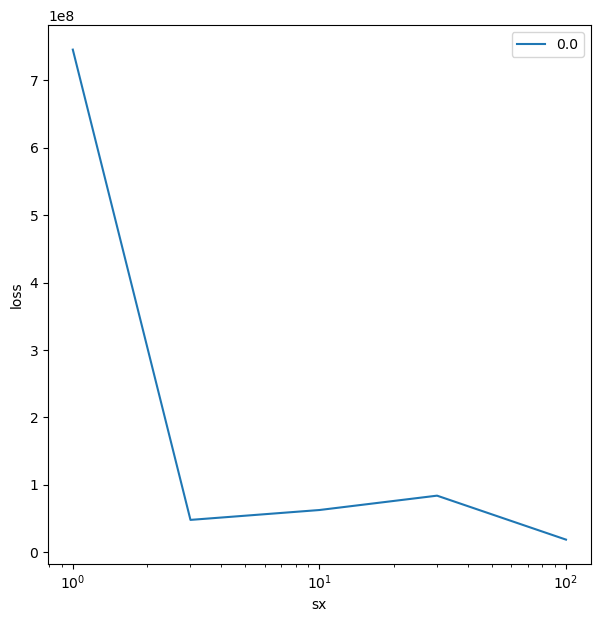

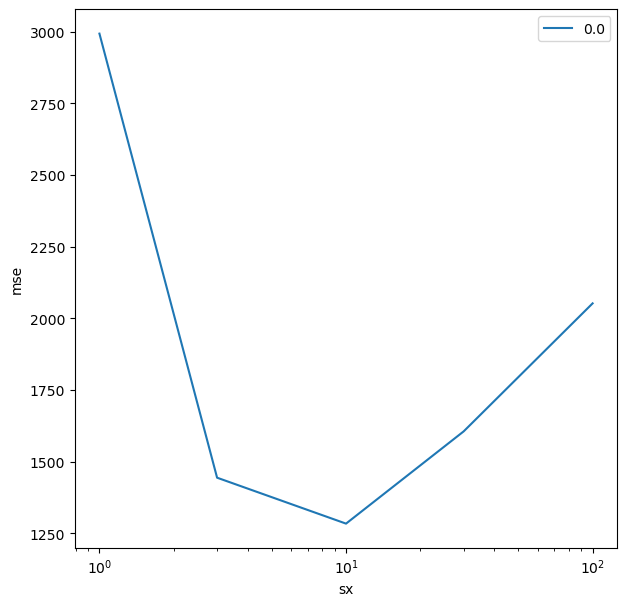

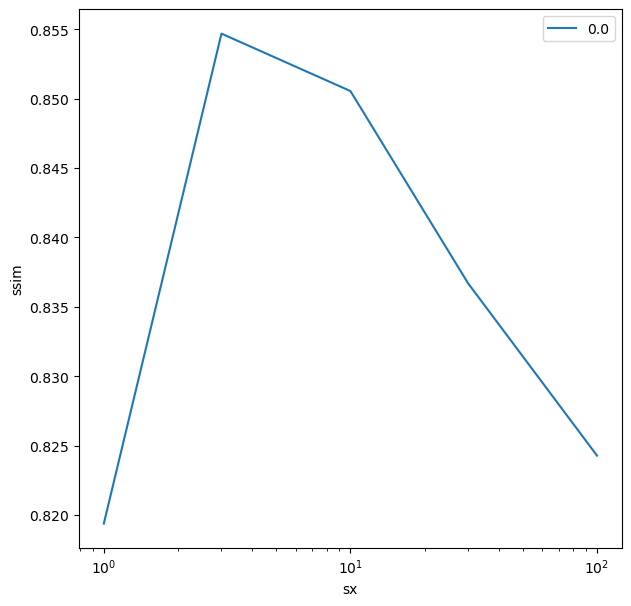

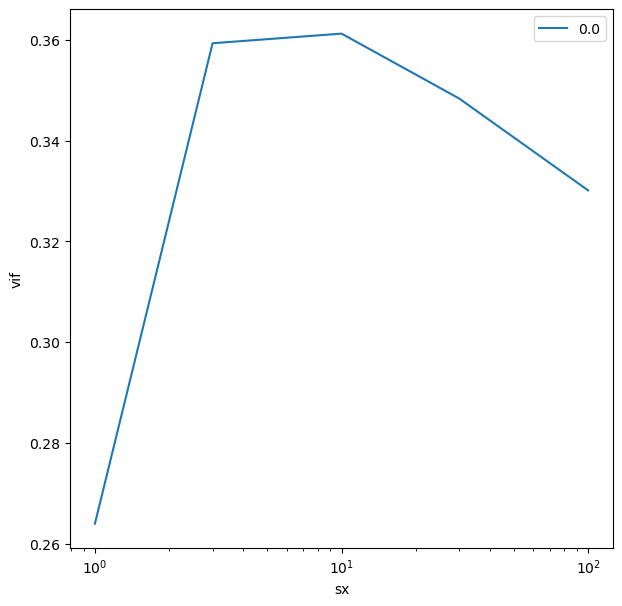

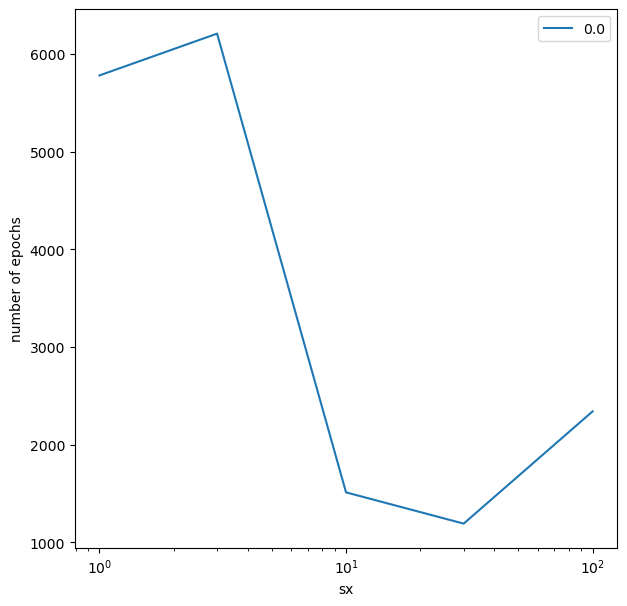

In [8]:
def plot_grid_search(values, vx, vy, ylabel, fig_name):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax.semilogx(vx, values)
    ax.legend(vy)
    ax.set_xlabel("sx")
    ax.set_ylabel(ylabel)

    fig.savefig(os.path.join(base_dir, fig_name+".png"))
    tikzplotlib.save(os.path.join(base_dir, fig_name+".tex"), fig)

plot_grid_search(final_losses, parameter1, parameter2, "loss", "grid_search_loss")
plot_grid_search(mses, parameter1, parameter2, "mse", "grid_search_mse")
plot_grid_search(ssims, parameter1, parameter2, "ssim", "grid_search_ssim")
plot_grid_search(vifs, parameter1, parameter2, "vif", "grid_search_vif")
plot_grid_search(total_num_epochs, parameter1, parameter2, "number of epochs", "grid_search_num_epochs")